# Lab: Word Embeddings in Digital Forensics

**Objective**: Learn how word embeddings represent text as vectors and use them to analyze dark web forum posts in a digital forensics investigation. The goal is to identify the true alias of a cybercriminal, "The Ghost," from three candidates—"ShadowTrader," "DataReaper," or "CrypticVendor"—by uncovering semantic patterns in their posts.

**Background Story**:  
It’s 2025, and you’re Analyst Quinn, a member of the Cyber Threat Task Force. A hacker known only as "The Ghost" has been wreaking havoc, selling stolen data—credit cards, passwords, and corporate secrets—on a dark web forum. The Task Force has intercepted three anonymous posts believed to be authored by The Ghost. Forum users mention different aliases—"ShadowTrader (e.g., trading),"  "DataReaper (e.g., harvesting),"  "CrypticVendor (e..g, a vendor of hidden wares)," —but only one is their true identity. Your mission: use word embeddings to analyze these posts and determine which alias most likely belongs to The Ghost, cutting through the noise to reveal their real handle.

**Dataset**:  
Three dark web forum posts attributed to The Ghost:  
1. *"Selling fresh (credit) card dumps, cheap prices, fast delivery."*  
2. *"Got a haul of (login) credentials—banks, emails, you name it. DM for deals."*  
3. *"Hacked a corporate (database)—juicy secrets for sale, secure payments only."*  

**Goal**:  
Analyze the posts to extract key term, marked in "()", explore their semantic relationships, and predict The Ghost’s true alias—"ShadowTrader," "DataReaper," or "CrypticVendor"—based on their consistent language patterns.

In [1]:
# Install compatible versions: gensim 4.3.2 and scipy 1.10.1
!pip install gensim==4.3.2 scipy==1.10.1 numpy matplotlib -q

# Import libraries for embedding analysis and visualization
import gensim.downloader as api  # Access pre-trained embeddings
import numpy as np              # Handle vector math
import matplotlib.pyplot as plt # Visualize patterns

# Verify installations
import gensim
import scipy
print(f"Gensim version: {gensim.__version__}")
print(f"Scipy version: {scipy.__version__}")
print("Forensic toolkit ready, Agent Riley!")

Gensim version: 4.3.2
Scipy version: 1.10.1
Forensic toolkit ready, Agent Riley!


In [2]:
# Load pre-trained Word2Vec model (Google News, 300D vectors)
model = api.load("word2vec-google-news-300")

# Test with a key term from Post 1: "credit"
word = "credit"
vector = model[word]
print(f"Vector for '{word}' (first 5 dimensions): {vector[:5]}")
print(f"Vector length: {len(vector)}")

# Context: "credit" from "credit card dumps" is our first clue to The Ghost’s true alias

[==================================================] 100.0% 1662.8/1662.8MB downloaded
Vector for 'credit' (first 5 dimensions): [-0.01501465  0.19335938  0.01483154  0.07373047  0.24902344]
Vector length: 300


In [3]:
# Find words similar to "credit" to explore The Ghost’s focus
similar_words = model.most_similar("credit", topn=5)
print("\nWords similar to 'credit':")
for word, similarity in similar_words:
    print(f"{word}: {similarity:.3f}")

# Context: Do these terms (e.g., "login", "database") align with one alias over the others?


Words similar to 'credit':
Credit: 0.689
loan: 0.556
loans: 0.549
lending: 0.524
mortgage: 0.507


In [4]:
# Classic Word Embedding Example
# Demonstrate how embeddings capture relationships with "king - man + woman ≈ queen"
classic_result = model.most_similar(positive=["king", "woman"], negative=["man"], topn=1)
print("\nClassic Example: king - man + woman = ?")
print(f"Result: {classic_result[0][0]} (similarity: {classic_result[0][1]:.3f})")
print("This shows embeddings understand gender relationships—let’s visualize the relationships!")


Classic Example: king - man + woman = ?
Result: queen (similarity: 0.712)
This shows embeddings understand gender relationships—let’s visualize the relationships!



Classic Example: king - man + woman = ?
Result: queen (similarity: 0.712)


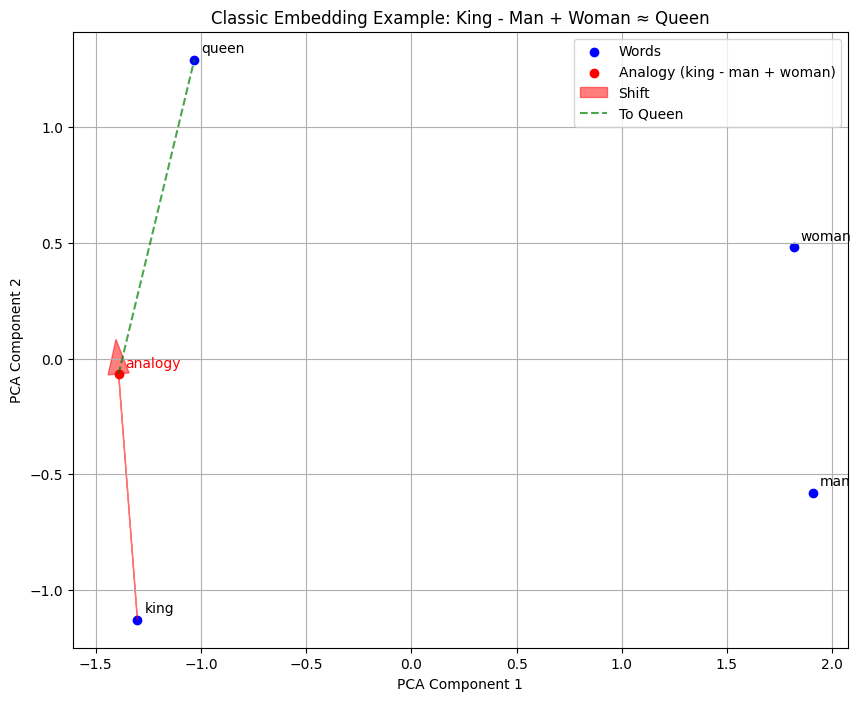

The red analogy point shifts from 'king' and should be near 'queen'—the green dashed line shows this connection!


In [5]:
# Visulize classic Word Embedding Example in a figure
# Demonstrate how embeddings capture relationships with "king - man + woman ≈ queen"
classic_words = ["king", "man", "woman", "queen"]
classic_vectors = [model[word] for word in classic_words]

# Compute the analogy vector explicitly: king - man + woman
analogy_vector = model["king"] - model["man"] + model["woman"]

# Perform the analogy to get the closest word (should be "queen")
classic_result = model.most_similar(positive=["king", "woman"], negative=["man"], topn=1)
print("\nClassic Example: king - man + woman = ?")
print(f"Result: {classic_result[0][0]} (similarity: {classic_result[0][1]:.3f})")

# Reduce to 2D using PCA for visualization (include analogy vector)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
all_vectors = classic_vectors + [analogy_vector]  # Add analogy vector
reduced_vectors = pca.fit_transform(all_vectors)

# Plot the classic embeddings with analogy highlighted
plt.figure(figsize=(10, 8))
# Plot the four words in blue
for i, word in enumerate(classic_words):
    plt.scatter(reduced_vectors[i, 0], reduced_vectors[i, 1], c="blue", label="Words" if i == 0 else "")
    plt.annotate(word, (reduced_vectors[i, 0], reduced_vectors[i, 1]), xytext=(5, 5), textcoords="offset points")
# Plot the analogy vector in red
plt.scatter(reduced_vectors[4, 0], reduced_vectors[4, 1], c="red", label="Analogy (king - man + woman)")
plt.annotate("analogy", (reduced_vectors[4, 0], reduced_vectors[4, 1]), xytext=(5, 5), textcoords="offset points", c="red")
# Draw an arrow from "king" to the analogy point
plt.arrow(reduced_vectors[0, 0], reduced_vectors[0, 1],
          reduced_vectors[4, 0] - reduced_vectors[0, 0],
          reduced_vectors[4, 1] - reduced_vectors[0, 1],
          color="red", alpha=0.5, head_width=0.1, label="Shift")
# Draw a dashed line from analogy to "queen" to show the intended result
queen_idx = classic_words.index("queen")
plt.plot([reduced_vectors[4, 0], reduced_vectors[queen_idx, 0]],
         [reduced_vectors[4, 1], reduced_vectors[queen_idx, 1]],
         "g--", label="To Queen", alpha=0.7)
plt.title("Classic Embedding Example: King - Man + Woman ≈ Queen")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.show()
print("The red analogy point shifts from 'king' and should be near 'queen'—the green dashed line shows this connection!")



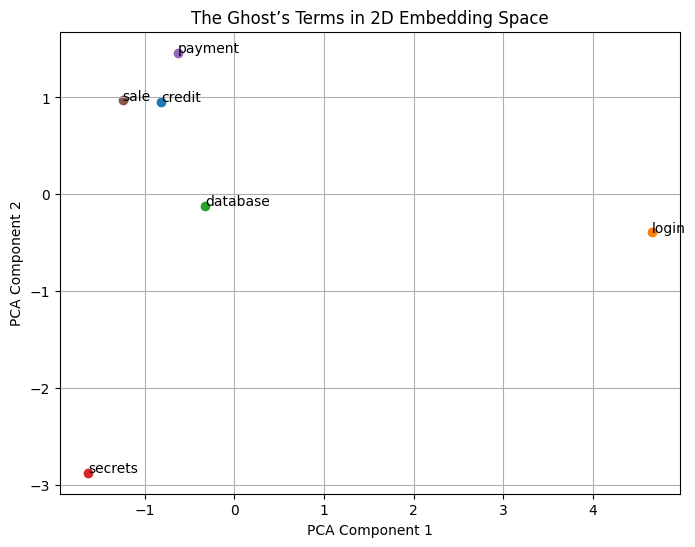

In [6]:
# Select key terms from the posts and alias-related words
words = ["credit", "login", "database", "secrets", "payment", "sale"]
vectors = [model[word] for word in words]

# Reduce to 2D using PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(vectors)

# Plot the terms
plt.figure(figsize=(8, 6))
for i, word in enumerate(words):
    plt.scatter(reduced_vectors[i, 0], reduced_vectors[i, 1])
    plt.annotate(word, (reduced_vectors[i, 0], reduced_vectors[i, 1]))
plt.title("The Ghost’s Terms in 2D Embedding Space")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()

# Context: Clusters might hint at The Ghost’s alias—e.g., "sale" near "credit" for "ShadowTrader"

In [7]:
# Compare key post terms to alias-related terms
post_terms = ["credit", "login", "database"]  # From Posts 1, 2, 3
aliases = ["trader", "reaper", "vendor"]     # Simplified from ShadowTrader, DataReaper, CrypticVendor

# Calculate average similarity between post terms and each alias term
for alias in aliases:
    similarities = [model.similarity(post_term, alias) for post_term in post_terms]
    avg_similarity = np.mean(similarities)
    print(f"Average similarity of post terms to '{alias}': {avg_similarity:.3f}")

# Context: Higher similarity to "trader," "reaper," or "vendor" suggests The Ghost’s alias

Average similarity of post terms to 'trader': 0.049
Average similarity of post terms to 'reaper': 0.032
Average similarity of post terms to 'vendor': 0.130


### Conclusion

*   CrypticVendor is the hacker's alias.